In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sqlalchemy import create_engine
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_absolute_error
from statsmodels.tools.eval_measures import mse, rmse
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import Ridge
import cpi
from sklearn import tree
import warnings
from IPython.display import Image
import pydotplus
import graphviz
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
warnings.filterwarnings('ignore')
from sklearn import preprocessing
from sklearn import utils
import seaborn as sns
from sklearn import neighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from time import time
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC
from sklearn import metrics
from imblearn.ensemble import BalancedRandomForestClassifier

C:\Users\Pat\Anaconda3\lib\site-packages\cpi\__init__.py:46: StaleDataWarning: CPI data is out of date. To accurately inflate to today's dollars, you must run `cpi.update()`.
  warnings.warn(StaleDataWarning())
Using TensorFlow backend.


Link to presentation slides:


**Data Set Information:**

See link for descriptions of features. Description in link detailed below.

https://archive.ics.uci.edu/ml/datasets/Drug+consumption+%28quantified%29


*From link:* Database contains records for 1885 respondents. For each respondent 12 attributes are known: Personality measurements which include NEO-FFI-R (neuroticism, extraversion, openness to experience, agreeableness, and conscientiousness), BIS-11 (impulsivity), and ImpSS (sensation seeking), level of education, age, gender, country of residence and ethnicity. All input attributes are originally categorical and are quantified. After quantification values of all input features can be considered as real-valued. In addition, participants were questioned concerning their use of 18 legal and illegal drugs (alcohol, amphetamines, amyl nitrite, benzodiazepine, cannabis, chocolate, cocaine, caffeine, crack, ecstasy, heroin, ketamine, legal highs, LSD, methadone, mushrooms, nicotine and volatile substance abuse and one fictitious drug (Semeron) which was introduced to identify over-claimers. For each drug they have to select one of the answers: never used the drug, used it over a decade ago, or in the last decade, year, month, week, or day.

**CLEANING DATA**

In [2]:
drug_df = pd.read_csv(r'C:\Users\Pat\Documents\Thinkful\Files\drug_consumption.data', header =  None,
                     names = ['ID', 'Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS', 'Acohol', 'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caffeine', 'Cannabis', 'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semeron', 'VSA'])

col = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity']
d_col = ['Acohol', 'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caffeine', 'Cannabis', 'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semeron']
p_col = ['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']
c_col = d_col + p_col

for c in col:
    drug_df[c] = drug_df[c].astype(str).apply(lambda x: x[:8] if x[0] == '-' else x[:7])

equiv1 = {'-0.95197':'18-24', '-0.07854':'25-34', '0.49788':'35-44', '1.09449':'45-54', '1.82213':'55-64', '2.59171':'65+'}
equiv2 = {'0.48246':'Female', '-0.48246':'Male'}
equiv3 = {'-2.43591':'Left Before 16', '-1.7379':'Left at 16', '-1.43719':'Left at 17', '-1.22751':'Left at 18', '-0.61113':'Some College', '-0.05921':'Professional Certificate/Diploma', '0.45468':'College Degree', '1.16365':'Masters Degree', '1.98437':'Doctorate Degree'}
equiv4 = {'-0.09765':'Australia', '0.24923':'Canada', '-0.46841':'New Zealand', '-0.28519':'Other', '0.21128':'Republic of Ireland', '0.96082':'UK', '-0.57009':'USA'}
equiv5 = {'-0.50212':'Asian', '-1.10702':'Black', '1.90725':'Mixed-Black/Asian', '0.126':'Mixed-White/Asian', '-0.22166':'Mixed-White/Black', '0.1144':'Other', '-0.31685':'White'}
# equiv6 = {'CL0':'Never', 'CL1':'10+ years', 'CL2':'Last 10 years', 'CL3':'Last year', 'CL4':'Last month', 'CL5':'Last week', 'CL6':'Last Day'}
equiv6 = {'CL0':'No', 'CL1':'Yes', 'CL2':'Yes', 'CL3':'Yes', 'CL4':'Yes', 'CL5':'Yes', 'CL6':'Yes'}

drug_df['Age'] = drug_df['Age'].map(equiv1)
drug_df['Gender'] = drug_df['Gender'].map(equiv2)
drug_df['Education'] = drug_df['Education'].map(equiv3)
drug_df['Country'] = drug_df['Country'].map(equiv4)
drug_df['Ethnicity'] = drug_df['Ethnicity'].map(equiv5)

for c in d_col:
    drug_df[c] = drug_df[c].map(equiv6)

drug_df = drug_df.drop('VSA', axis = 1)

print(drug_df.head())

   ID    Age  Gender                         Education Country  \
0   1  35-44  Female  Professional Certificate/Diploma      UK   
1   2  25-34    Male                  Doctorate Degree      UK   
2   3  35-44    Male  Professional Certificate/Diploma      UK   
3   4  18-24  Female                    Masters Degree      UK   
4   5  35-44  Female                  Doctorate Degree      UK   

           Ethnicity   Nscore   Escore   Oscore   Ascore  ...  Crack  Ecstasy  \
0  Mixed-White/Asian  0.31287 -0.57545 -0.58331 -0.91699  ...     No       No   
1              White -0.67825  1.93886  1.43533  0.76096  ...    Yes       No   
2              White -0.46725  0.80523 -0.84732 -1.62090  ...     No       No   
3              White -0.14882 -0.80615 -0.01928  0.59042  ...     No       No   
4              White  0.73545 -1.63340 -0.45174 -0.30172  ...    Yes       No   

   Heroin Ketamine Legalh  LSD Meth Mushrooms Nicotine Semeron  
0      No       No     No   No   No       Yes      

**EXPLORATORY DATA ANALYSIS**

In [3]:
drug_df.describe()

,ID,Nscore,Escore,Oscore,Ascore,Cscore,Impulsive,SS
count,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000,1885.000000
mean,945.294960,0.000047,-0.000163,-0.000534,-0.000245,-0.000386,0.007216,-0.003292
std,545.167641,0.998106,0.997448,0.996229,0.997440,0.997523,0.954435,0.963701
min,1.000000,-3.464360,-3.273930,-3.273930,-3.464360,-3.464360,-2.555240,-2.078480
25%,474.000000,-0.678250,-0.695090,-0.717270,-0.606330,-0.652530,-0.711260,-0.525930
50%,946.000000,0.042570,0.003320,-0.019280,-0.017290,-0.006650,-0.217120,0.079870
75%,1417.000000,0.629670,0.637790,0.723300,0.760960,0.584890,0.529750,0.765400
max,1888.000000,3.273930,3.273930,2.901610,3.464360,3.464360,2.901610,1.921730


In [4]:
for column in c_col:
    le = LabelEncoder()
    drug_df[column] = le.fit_transform(drug_df[column])

In [5]:
drug_df.dtypes

ID            int64
Age          object
Gender       object
Education    object
Country      object
Ethnicity    object
Nscore        int64
Escore        int64
Oscore        int64
Ascore        int64
Cscore        int64
Impulsive     int64
SS            int64
Acohol        int32
Alcohol       int32
Amphet        int32
Amyl          int32
Benzos        int32
Caffeine      int32
Cannabis      int32
Chocolate     int32
Cocaine       int32
Crack         int32
Ecstasy       int32
Heroin        int32
Ketamine      int32
Legalh        int32
LSD           int32
Meth          int32
Mushrooms     int32
Nicotine      int32
Semeron       int32
dtype: object

In [6]:
drug_df.isna().sum()

ID           0
Age          0
Gender       0
Education    0
Country      0
Ethnicity    0
Nscore       0
Escore       0
Oscore       0
Ascore       0
Cscore       0
Impulsive    0
SS           0
Acohol       0
Alcohol      0
Amphet       0
Amyl         0
Benzos       0
Caffeine     0
Cannabis     0
Chocolate    0
Cocaine      0
Crack        0
Ecstasy      0
Heroin       0
Ketamine     0
Legalh       0
LSD          0
Meth         0
Mushrooms    0
Nicotine     0
Semeron      0
dtype: int64

Text(0.5, 1.0, 'Nscore')

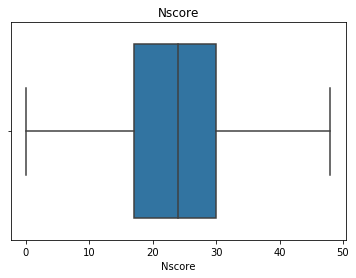

In [7]:
sns.boxplot(x = drug_df['Nscore']).set_title('Nscore')

Text(0.5, 1.0, 'Escore')

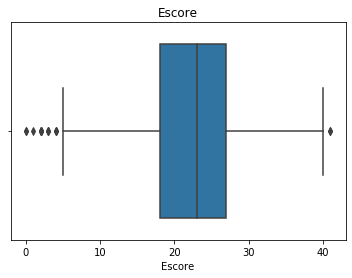

In [8]:
sns.boxplot(x = drug_df['Escore']).set_title('Escore')

Text(0.5, 1.0, 'Oscore')

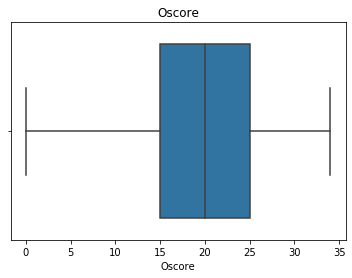

In [9]:
sns.boxplot(x = drug_df['Oscore']).set_title('Oscore')

Text(0.5, 1.0, 'Ascore')

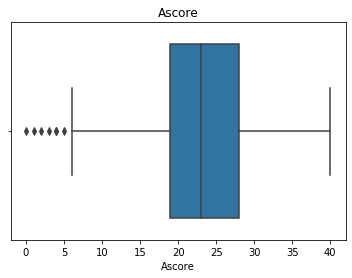

In [10]:
sns.boxplot(x = drug_df['Ascore']).set_title('Ascore')

Text(0.5, 1.0, 'Cscore')

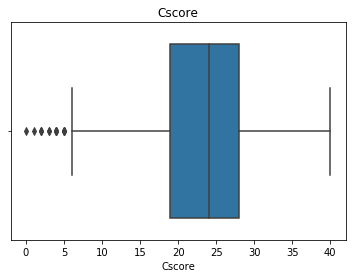

In [11]:
sns.boxplot(x = drug_df['Cscore']).set_title('Cscore')

Text(0.5, 1.0, 'Impulsive')

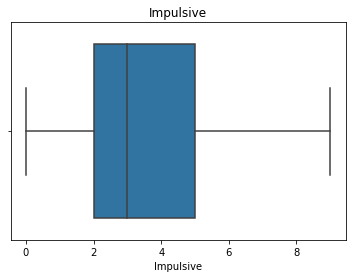

In [12]:
sns.boxplot(x = drug_df['Impulsive']).set_title('Impulsive')

Text(0.5, 1.0, 'SS')

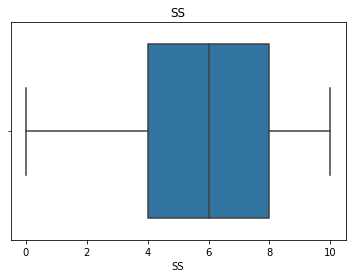

In [13]:
sns.boxplot(x = drug_df['SS']).set_title('SS')

Text(0.5, 1.0, 'Age Distribution')

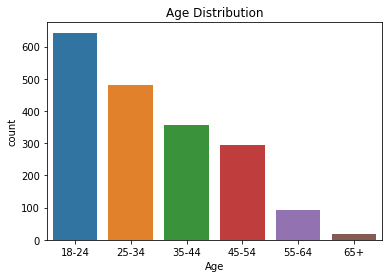

In [14]:
age_index = ['18-24', '25-34', '35-44', '45-54', '55-64', '65+']
sns.countplot(x = drug_df['Age'], order = age_index).set_title('Age Distribution')

Text(0.5, 1.0, 'Gender Distribution')

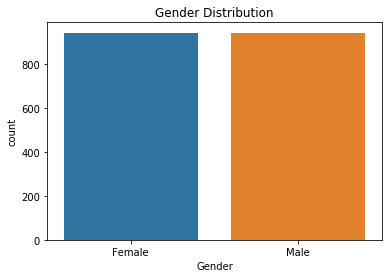

In [15]:
sns.countplot(x = drug_df['Gender']).set_title('Gender Distribution')

Text(0.5, 1.0, 'Nationality Distribution')

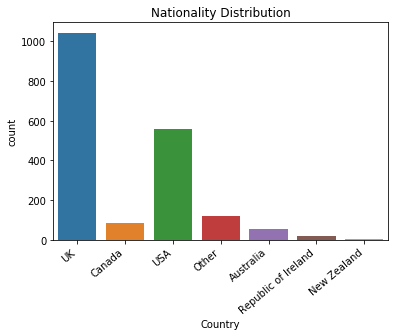

In [16]:
country_cnt = sns.countplot(x = drug_df['Country'])
country_cnt.set_xticklabels(country_cnt.get_xticklabels(), rotation=40, ha="right")
country_cnt.set_title('Nationality Distribution')

Text(0.5, 1.0, 'Education Distribution')

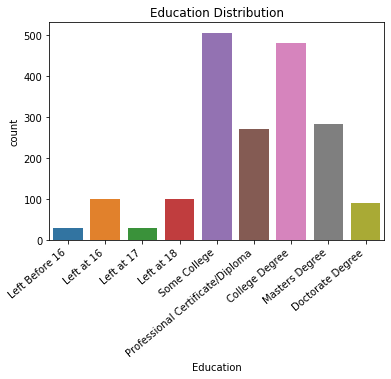

In [17]:
ed_index = ['Left Before 16', 'Left at 16', 'Left at 17', 'Left at 18', 'Some College', 'Professional Certificate/Diploma', 'College Degree', 'Masters Degree', 'Doctorate Degree']
ed_cnt = sns.countplot(x = drug_df['Education'], order = ed_index)
ed_cnt.set_xticklabels(ed_cnt.get_xticklabels(), rotation=40, ha="right")
ed_cnt.set_title('Education Distribution')

Text(0.5, 1.0, 'Ethnicity Distribution')

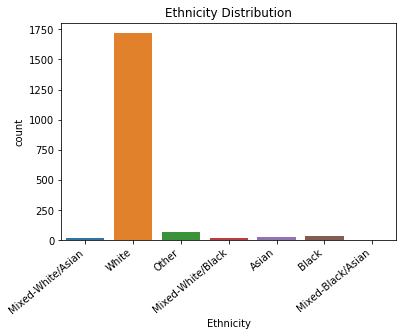

In [18]:
eth_cnt = sns.countplot(x = drug_df['Ethnicity'])
eth_cnt.set_xticklabels(eth_cnt.get_xticklabels(), rotation=40, ha="right")
eth_cnt.set_title('Ethnicity Distribution')

Text(0.5, 1.0, 'LSD Distribution')

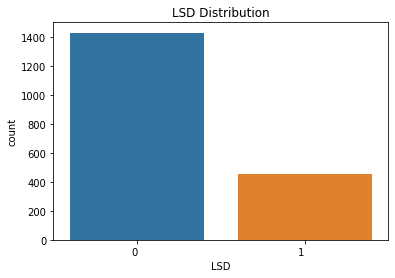

In [19]:
# msh_cnt = sns.countplot(x = drug_df['Alcohol'], order = freq_index)
msh_cnt = sns.countplot(x = drug_df['LSD'])
# msh_cnt = sns.countplot(x = drug_df['Mushrooms'])
msh_cnt.set_xticklabels(msh_cnt.get_xticklabels(), ha="right")
msh_cnt.set_title('LSD Distribution')

In [20]:
drug_df['LSD'].value_counts()

0    1429
1     456
Name: LSD, dtype: int64

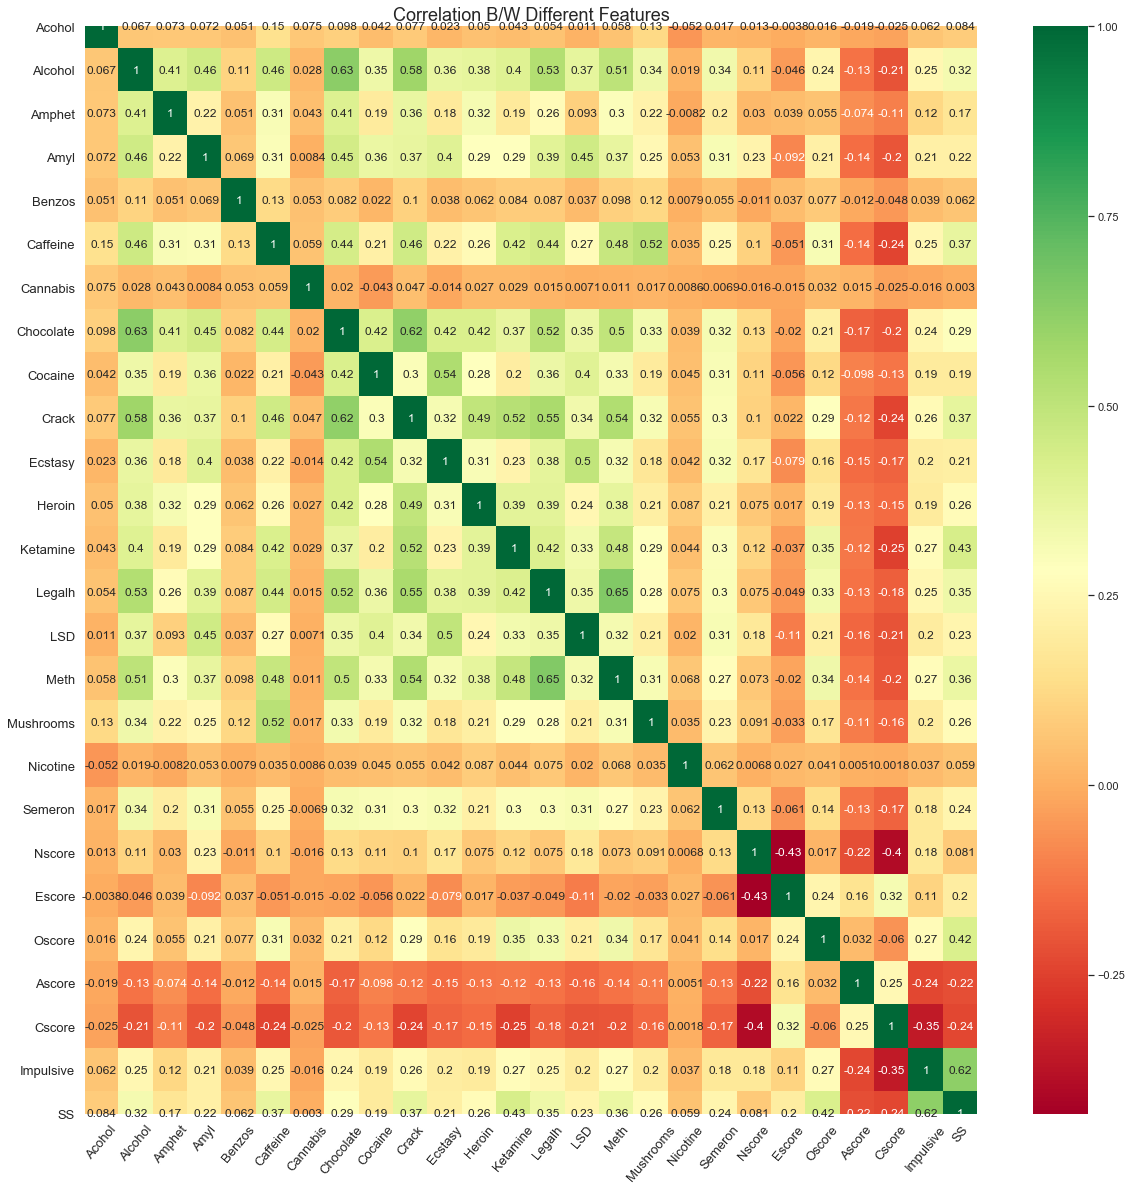

In [21]:
corrmat = drug_df[c_col].corr()

# print(corrmat)
plt.figure(figsize=(20,20))

sns.set(font_scale=1)
hm = sns.heatmap(corrmat,cmap = 'RdYlGn',annot=True,
             yticklabels = c_col, xticklabels = c_col)
plt.xticks(fontsize=13,rotation=50)
plt.yticks(fontsize=13)
plt.title("Correlation B/W Different Features",fontsize=18)
plt.show()

In [22]:
print(d_col)

['Acohol', 'Alcohol', 'Amphet', 'Amyl', 'Benzos', 'Caffeine', 'Cannabis', 'Chocolate', 'Cocaine', 'Crack', 'Ecstasy', 'Heroin', 'Ketamine', 'Legalh', 'LSD', 'Meth', 'Mushrooms', 'Nicotine', 'Semeron']


**SUPERVISED LEARNING MODELING**

Below I'll be trying the K-Nearest Neighbors, SVM, Decision Tree, and Random Forest methods. Due to the class imbalance I won't really be looking at accuracy, but rather at precision and recall. Afterwards I'll take the best performing model and try to deal with the class imbalance.

In [23]:
#Below I'm setting up the training/target sets

freq_index = ['Never', '10+ years', 'Last 10 years', 'Last year', 'Last month', 'Last week', 'Last Day']

# cat_feat = ['Age', 'Gender', 'Education']
cat_feat = ['Age', 'Gender', 'Education', 'Country', 'Ethnicity', 'Cannabis']
num_feat = ['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']
msh_class = drug_df['Alcohol'].unique()


X1 = drug_df[cat_feat]
X2 = drug_df[num_feat]
X3 = drug_df[cat_feat + num_feat]
Y = drug_df['LSD']


for c in cat_feat:
    X2 = pd.concat([X2, pd.get_dummies(drug_df[c], drop_first=True)], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size = 0.2, random_state = 465)

In [24]:
# print(drug_df.head())

**KNN**

In [25]:
print(num_feat)

['Nscore', 'Escore', 'Oscore', 'Ascore', 'Cscore', 'Impulsive', 'SS']


In [26]:
X_k = drug_df[num_feat]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_k, Y, test_size = 0.2, random_state = 465)

neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(X_train1,y_train1)
y_pred1 = neighbors.predict(X_test1)

In [27]:
print("Confusion Matrix: ")
print(confusion_matrix(y_test1, y_pred1)) 
print('')

print ("Accuracy : ") 
print(accuracy_score(y_test1,y_pred1)*100) 
print('')

print('Report:')
print(classification_report(y_test1, y_pred1))

Confusion Matrix: 
[[261  21]
 [ 69  26]]

Accuracy : 
76.12732095490716

Report:
              precision    recall  f1-score   support

           0       0.79      0.93      0.85       282
           1       0.55      0.27      0.37        95

    accuracy                           0.76       377
   macro avg       0.67      0.60      0.61       377
weighted avg       0.73      0.76      0.73       377



In [44]:
#Here I just grabbed the two features I found to be the most useful (thorugh some tinkering)
#for the purpose of producing a 2-D visual
#It does not perform as well with 

X_k = drug_df[['Impulsive', 'Cscore']]

X_train1, X_test1, y_train1, y_test1 = train_test_split(X_k, Y, test_size = 0.2, random_state = 465)

neighbors = KNeighborsClassifier(n_neighbors=5)
neighbors.fit(X_train1,y_train1)
y_pred1 = neighbors.predict(X_test1)

In [45]:
print("Confusion Matrix: ") 
print(confusion_matrix(y_test1, y_pred1)) 
print('')

print ("Accuracy : ") 
print(accuracy_score(y_test1,y_pred1)*100) 
print('')

print("Report : ")
print(classification_report(y_test1, y_pred1)) 

Confusion Matrix: 
[[261  21]
 [ 80  15]]

Accuracy : 
73.20954907161804

Report : 
              precision    recall  f1-score   support

           0       0.77      0.93      0.84       282
           1       0.42      0.16      0.23        95

    accuracy                           0.73       377
   macro avg       0.59      0.54      0.53       377
weighted avg       0.68      0.73      0.68       377



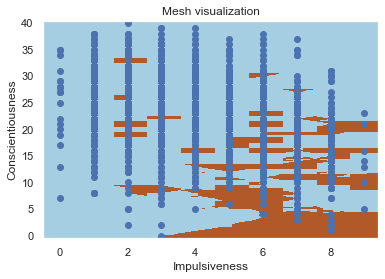

In [46]:
# Mesh size.
h = 0.1

# Plot the decision boundary. We assign a color to each point in the mesh.
x_min = X_k.iloc[:, 0].min() - .5
x_max = X_k.iloc[:, 0].max() + .5
y_min = X_k.iloc[:, 1].min() - .5
y_max = X_k.iloc[:, 1].max() + .5
xx, yy = np.meshgrid(
    np.arange(x_min, x_max, h),
    np.arange(y_min, y_max, h)
)
Z = neighbors.predict(np.c_[xx.ravel(), yy.ravel()])

# Put the result into a color plot.
Z = Z.reshape(xx.shape)
plt.figure(1, figsize=(6, 4))
plt.set_cmap(plt.cm.Paired)

# print(xx)
# print(yy)
# print(Z)

plt.pcolormesh(xx, yy, Z)

# Add the training points to the plot.
plt.scatter(X_k.iloc[:, 0], X_k.iloc[:, 1])
plt.xlabel('Impulsiveness')
plt.ylabel('Conscientiousness')
plt.title('Mesh visualization')

plt.xlim(xx.min(), xx.max())
plt.ylim(yy.min(), yy.max())

plt.show()

**SVM**

In [31]:
def plot_confusion_metrix(y_test,model_test):
    cm = metrics.confusion_matrix(y_test, model_test)
    plt.figure(1)
    plt.clf()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Wistia)
    classNames = ['Non-User','User']
    plt.title('Confusion Matrix')
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    tick_marks = np.arange(len(classNames))
    plt.xticks(tick_marks, classNames)
    plt.yticks(tick_marks, classNames)
    s = [['TN','FP'], ['FN', 'TP']]
    for i in range(2):
        for j in range(2):
            plt.text(j,i, str(s[i][j])+" = "+str(cm[i][j]))
    plt.show()
    
def report_performance(model):

    model_test = model.predict(X_test)

    print("\n\nConfusion Matrix:")
    print("{0}".format(metrics.confusion_matrix(y_test, model_test)))
    print("\n\nClassification Report: ")
    print(metrics.classification_report(y_test, model_test))

In [32]:
svm = SVC(kernel="rbf", C=2,random_state=0)
svm.fit(X_train, y_train.ravel())
y_pred = svm.predict(X_test)


print("Confusion Matrix: ") 
print(confusion_matrix(y_test, y_pred)) 
print('')

print ("Accuracy : ")
print(accuracy_score(y_test,y_pred)*100) 
print('')

print("Report : ")
print(classification_report(y_test, y_pred)) 

Confusion Matrix: 
[[257  25]
 [ 81  14]]

Accuracy : 
71.88328912466844

Report : 
              precision    recall  f1-score   support

           0       0.76      0.91      0.83       282
           1       0.36      0.15      0.21        95

    accuracy                           0.72       377
   macro avg       0.56      0.53      0.52       377
weighted avg       0.66      0.72      0.67       377



**Decision Tree**

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size = 0.2, random_state = 465)
decision_tree = tree.DecisionTreeClassifier(
    criterion='gini',
    random_state = 465
)

decision_tree.fit(X_train, y_train)
y_pred = decision_tree.predict(X_test)


print("Confusion Matrix: ") 
print(confusion_matrix(y_test, y_pred)) 
print('')

print ("Accuracy : ")
print(accuracy_score(y_test,y_pred)*100) 
print('')

print("Report : ")
print(classification_report(y_test, y_pred)) 

Confusion Matrix: 
[[224  58]
 [ 54  41]]

Accuracy : 
70.29177718832891

Report : 
              precision    recall  f1-score   support

           0       0.81      0.79      0.80       282
           1       0.41      0.43      0.42        95

    accuracy                           0.70       377
   macro avg       0.61      0.61      0.61       377
weighted avg       0.71      0.70      0.70       377



**Random Forest**

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size = 0.25, random_state = 465)
rfc = ensemble.RandomForestClassifier(n_estimators = 500, random_state = 465)
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)

def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

param_grid = {"max_depth": [3, None],
              "max_features": [1, 3, 10],
              "min_samples_split": [2, 3, 10],
              "criterion": ["gini", "entropy"]}

# # run grid search
grid_search = GridSearchCV(rfc, param_grid=param_grid, cv=5, iid=False)
start = time()
grid_search.fit(X_train, y_train)

print("GridSearchCV took %.2f seconds for %d candidate parameter settings."
      % (time() - start, len(grid_search.cv_results_['params'])))
report(grid_search.cv_results_)

y_pred = grid_search.predict(X_test)

print("Confusion Matrix: ") 
print(confusion_matrix(y_test, y_pred)) 
print('')

print ("Accuracy : ")
print(accuracy_score(y_test,y_pred)*100) 
print('')

print("Report : ")
print(classification_report(y_test, y_pred)) 

GridSearchCV took 123.20 seconds for 36 candidate parameter settings.
Model with rank: 1
Mean validation score: 0.783 (std: 0.019)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 1, 'min_samples_split': 2}

Model with rank: 2
Mean validation score: 0.781 (std: 0.017)
Parameters: {'criterion': 'gini', 'max_depth': None, 'max_features': 1, 'min_samples_split': 3}

Model with rank: 3
Mean validation score: 0.779 (std: 0.020)
Parameters: {'criterion': 'entropy', 'max_depth': 3, 'max_features': 10, 'min_samples_split': 10}

Model with rank: 3
Mean validation score: 0.779 (std: 0.026)
Parameters: {'criterion': 'entropy', 'max_depth': None, 'max_features': 3, 'min_samples_split': 2}

Confusion Matrix: 
[[341  15]
 [ 81  35]]

Accuracy : 
79.66101694915254

Report : 
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       356
           1       0.70      0.30      0.42       116

    accuracy                           0.8

The random forest classifier performed the best, so I'll take this model with the best performing parameters and try to deal with the class imbalance to get a better looking confusion matrix. I'll use both a balanced and a weighted random forest.

In [38]:
X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size = 0.25, random_state = 465)
rfc = ensemble.RandomForestClassifier(n_estimators = 500, criterion='entropy', 
                                      max_depth=None, max_features=1, min_samples_split=2, 
                                      random_state = 465, class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)


print("Confusion Matrix: ") 
print(confusion_matrix(y_test, y_pred)) 
print('')

print ("Accuracy : ")
print(accuracy_score(y_test,y_pred)*100) 
print('')

print("Report : ")
print(classification_report(y_test, y_pred))

# SELECTED MODEL

Confusion Matrix: 
[[340  16]
 [ 79  37]]

Accuracy : 
79.87288135593221

Report : 
              precision    recall  f1-score   support

           0       0.81      0.96      0.88       356
           1       0.70      0.32      0.44       116

    accuracy                           0.80       472
   macro avg       0.75      0.64      0.66       472
weighted avg       0.78      0.80      0.77       472



In [39]:
feature_importances = pd.DataFrame(rfc.feature_importances_,
                                   index = X_train.columns,
                                    columns=['importance']).sort_values('importance', ascending=False)

print(feature_importances)

                                  importance
Oscore                              0.104129
Nscore                              0.103457
Cscore                              0.099530
Ascore                              0.098331
Escore                              0.096656
SS                                  0.085928
Impulsive                           0.079185
UK                                  0.060274
USA                                 0.060034
Male                                0.029270
Some College                        0.022714
25-34                               0.016204
Masters Degree                      0.015697
35-44                               0.015066
45-54                               0.013254
Professional Certificate/Diploma    0.012648
Left at 18                          0.009364
Other                               0.008797
Left at 16                          0.008100
White                               0.008000
Canada                              0.007608
Doctorate 

In [36]:
X_train, X_test, y_train, y_test = train_test_split(X2, Y, test_size = 0.25, random_state = 465)
rfc = BalancedRandomForestClassifier(n_estimators = 500, criterion='entropy', 
                                      max_depth=None, max_features=1, min_samples_split=2, 
                                      random_state = 465, class_weight='balanced')
rfc.fit(X_train, y_train)
y_pred = rfc.predict(X_test)



print("Confusion Matrix: ") 
print(confusion_matrix(y_test, y_pred)) 
print('')

print ("Accuracy : ")
print(accuracy_score(y_test,y_pred)*100) 
print('')

print("Report : ")
print(classification_report(y_test, y_pred)) 

Confusion Matrix: 
[[115 241]
 [  5 111]]

Accuracy : 
47.88135593220339

Report : 
              precision    recall  f1-score   support

           0       0.96      0.32      0.48       356
           1       0.32      0.96      0.47       116

    accuracy                           0.48       472
   macro avg       0.64      0.64      0.48       472
weighted avg       0.80      0.48      0.48       472



It looks like it's much better to under-sample the 0 class as opposed to under sampling the 1 class, as the recall suffers a lot when the majority class is under-sampled. Thus I'll take the weighted random forest classifier as my final selection. It should come as no surprise that the random forest performed better than the decision tree model, as the former is an ensemble model composed of many decision trees. Furthermore, if I wanted to further improve my random forest I could use one or more of the various boosting models available. 

I would say that my model performed decently well (not great) with regards to precision, but not well at all when it comes to recall. This probably has a lot to with the small amount of people who have tried LSD. Over-sampling that population bumped up recall a couple points, but it did not help all that much. As I mentioned in the previous slide there are ways I’d be able to further tinker with it, but being this was more about the methodologies involved I was advised that further tinkering would be slightly outside the scope of this project. Fortunately, neither Type I nor Type II errors will have grave consequences in the context of this study. 
Any correlation between personality traits and drug use would useful from an educational standpoint, but in practice I feel like it would be difficult to put any model with predictive value to use.
